Step 1: Load and Merge Data
We first need to load the datasets and merge them into a single DataFrame.

In [11]:
import pandas as pd

# Load datasets
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

# Merge datasets
merged_data = transactions.merge(customers, on="CustomerID").merge(products, on="ProductID")

# Display the first few rows of the merged data
print(merged_data.head())


  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region  SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe  2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia  2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe  2024-04-04   
3      601.36   300.68  Travis Campbell  South America  2024-04-11   
4      902.04   300.68    Timothy Perez         Europe  2022-03-15   

                       ProductName     Category  Price_y  
0  ComfortLiving Bluetooth Speaker  Electronics   300.68  
1  ComfortLiving Bluetooth Speaker

Step 2: Feature Engineering
Aggregate data for each customer to create meaningful features:

1. Total Spending: Sum of the TotalValue column for each customer.
2. Transaction Count: Number of transactions.
3. Most Purchased Category: The most frequently purchased product category.

In [13]:
# Aggregate customer features
customer_features = merged_data.groupby("CustomerID").agg({
    "TotalValue": "sum",  # Total spending
    "TransactionID": "count",  # Transaction count
    "Category": lambda x: x.mode()[0]  # Most purchased category
}).rename(columns={"TotalValue": "TotalSpending", "TransactionID": "TransactionCount"})

# One-hot encode the 'Category' column
customer_features = pd.get_dummies(customer_features, columns=["Category"], drop_first=True)

# Display the first few rows
print(customer_features.head())


            TotalSpending  TransactionCount  Category_Clothing  \
CustomerID                                                       
C0001             3354.52                 5              False   
C0002             1862.74                 4               True   
C0003             2725.38                 4              False   
C0004             5354.88                 8              False   
C0005             2034.24                 3              False   

            Category_Electronics  Category_Home Decor  
CustomerID                                             
C0001                       True                False  
C0002                      False                False  
C0003                      False                 True  
C0004                      False                False  
C0005                       True                False  


Step 3: One-Hot Encoding and Normalization
Convert categorical features into numerical values using one-hot encoding, and scale the numerical columns to a 0–1 range.

In [17]:
from sklearn.preprocessing import MinMaxScaler

# Ensure all columns except 'CustomerID' are numeric and explicitly convert to float64
customer_features.iloc[:, 1:] = customer_features.iloc[:, 1:].apply(lambda x: x.astype(float))

# Normalize the numerical features using MinMaxScaler
scaler = MinMaxScaler()
customer_features.iloc[:, 1:] = scaler.fit_transform(customer_features.iloc[:, 1:])

# Display the updated DataFrame
print(customer_features.head())


            TotalSpending  TransactionCount  Category_Clothing  \
CustomerID                                                       
C0001             3354.52               0.4                0.0   
C0002             1862.74               0.3                1.0   
C0003             2725.38               0.3                0.0   
C0004             5354.88               0.7                0.0   
C0005             2034.24               0.2                0.0   

            Category_Electronics  Category_Home Decor  
CustomerID                                             
C0001                        1.0                  0.0  
C0002                        0.0                  0.0  
C0003                        0.0                  1.0  
C0004                        0.0                  0.0  
C0005                        1.0                  0.0  


Step 4: Determine Optimal Clusters
We'll use the Davies-Bouldin Index (DB Index) to identify the optimal number of clusters. A lower DB Index indicates better clustering.

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Calculate DB Index for clusters ranging from 2 to 10
cluster_metrics = {}

for k in range(2, 11):  # Try cluster sizes from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(customer_features.iloc[:, 1:])  # Exclude CustomerID
    
    # Calculate DB Index
    db_index = davies_bouldin_score(customer_features.iloc[:, 1:], labels)
    cluster_metrics[k] = db_index
    print(f"Number of Clusters: {k}, DB Index: {db_index:.3f}")

# Find the optimal number of clusters
optimal_k = min(cluster_metrics, key=cluster_metrics.get)
print(f"Optimal Number of Clusters: {optimal_k}")


Number of Clusters: 2, DB Index: 0.751
Number of Clusters: 3, DB Index: 0.644
Number of Clusters: 4, DB Index: 0.354
Number of Clusters: 5, DB Index: 0.365
Number of Clusters: 6, DB Index: 0.462
Number of Clusters: 7, DB Index: 0.475
Number of Clusters: 8, DB Index: 0.478
Number of Clusters: 9, DB Index: 0.526
Number of Clusters: 10, DB Index: 0.487
Optimal Number of Clusters: 4


Step 5: Apply Final K-Means Model
Fit the K-Means model with the optimal number of clusters and assign clusters to each customer.

In [21]:
# Fit the final K-Means model
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features["Cluster"] = final_kmeans.fit_predict(customer_features.iloc[:, 1:])

# Display the first few rows with cluster assignments
print(customer_features.head())


            TotalSpending  TransactionCount  Category_Clothing  \
CustomerID                                                       
C0001             3354.52               0.4                0.0   
C0002             1862.74               0.3                1.0   
C0003             2725.38               0.3                0.0   
C0004             5354.88               0.7                0.0   
C0005             2034.24               0.2                0.0   

            Category_Electronics  Category_Home Decor  Cluster  
CustomerID                                                      
C0001                        1.0                  0.0        1  
C0002                        0.0                  0.0        3  
C0003                        0.0                  1.0        2  
C0004                        0.0                  0.0        0  
C0005                        1.0                  0.0        1  


Step 6: Visualize Clusters
Reduce the data to two dimensions using PCA and plot the clusters.

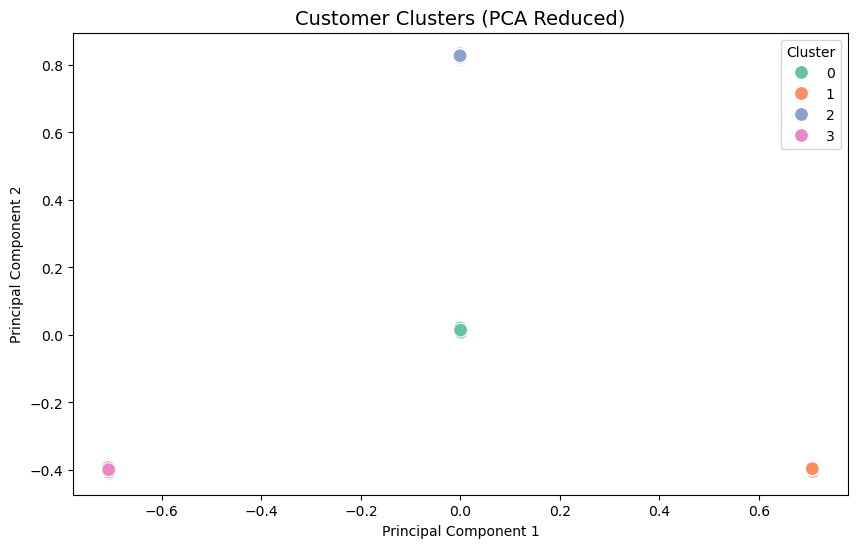

In [33]:
'''import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA

# Assuming customer_features is already defined
# Reduce features to 2 dimensions
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(customer_features.iloc[:, 1:-1])  # Exclude CustomerID and Cluster

# Create a DataFrame for visualization
reduced_df = pd.DataFrame(reduced_features, columns=["PC1", "PC2"])
reduced_df["Cluster"] = customer_features["Cluster"]

# Ensure 'Cluster' column is treated as a categorical variable
reduced_df["Cluster"] = reduced_df["Cluster"].astype(str)

# Scatter plot of clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=reduced_df, x="PC1", y="PC2", hue="Cluster", palette="Set2", s=100)
plt.title("Customer Clusters (PCA Reduced)", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Manually add legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, title="Cluster")

plt.show()'''

# Create a DataFrame for PCA-reduced features
reduced_df = pd.DataFrame(reduced_features, columns=["PC1", "PC2"])

# Add the 'Cluster' column from customer_features
reduced_df["Cluster"] = customer_features["Cluster"].values

# Scatter plot of clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=reduced_df, x="PC1", y="PC2", hue="Cluster", palette="Set2", s=100)
plt.title("Customer Clusters (PCA Reduced)", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()



Step 7: Save Results
Save the cluster assignments and DB Index metrics to CSV files.

In [35]:
# Save customer features with cluster assignments
customer_features.to_csv("FirstName_LastName_Clustering.csv", index=False)

# Save DB Index values
db_index_df = pd.DataFrame(list(cluster_metrics.items()), columns=["Number of Clusters", "DB Index"])
db_index_df.to_csv("FirstName_LastName_DBIndex.csv", index=False)

print("Clustering results and metrics saved as CSV files.")


Clustering results and metrics saved as CSV files.
